<a href="https://colab.research.google.com/github/musicjae/NLP/blob/master/seq2seq/seq2seq_with_pytorch_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
from google.colab import files
uploaded = files.upload() # 파일 업로드 기능 실행

for fn in uploaded.keys(): # 업로드된 파일 정보 출력
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

Saving 22.png to 22.png
User uploaded file "22.png" with length 77922 bytes


In [37]:
from IPython.display import Image

# 0. 데이터 준비

라벨을 가진 트레이닝 데이터를 준비하자. Torchtext를 사용하면 편리하다. 여기 있는 Multi30k는 다양한 언어의 번역 쌍 (번역 작업에 상응하는 소스 언어와 타겟 언어가 있어)이 있다.  
우리는 먼저 우리의 데이터를 토큰화 하기 위해 spacy를 사용한다.

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

import spacy
import numpy as np

import random
import math
import time

from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator  

In [5]:
import matplotlib.pyplot as plt

In [7]:
!python -m spacy download de

     |████████████████████████████████| 14.9MB 1.1MB/s 
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.5-cp36-none-any.whl size=14907056 sha256=d01a017d37157026ba1062d14bad36fff911828aebb0a2d1f84ad6db8dd66e24
  Stored in directory: /tmp/pip-ephem-wheel-cache-v4zjnxtp/wheels/ba/3f/ed/d4aa8e45e7191b7f32db4bfad565e7da1edbf05c916ca7a1ca
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')


In [8]:
spacy_german = spacy.load('de')
spacy_english = spacy.load('en')

## 1.1 문장 토큰화

In [9]:
def tok_ger(text):

    return [token.text for token in spacy_german.tokenizer(text)]

def tok_eng(text):

    return [token.text for token in spacy_english.tokenizer(text)][::-1] # source sentence의 역순 입력은 퍼포먼스 향상에 도움을 준다. (이전 세미나에서 이것을 언급했었다.)

In [10]:
SOURCE = Field(tokenize= tok_eng, init_token='<sos>',eos_token='<eos>',lower=True)
TARGET = Field(tokenize = tok_ger, init_token='<sos>',eos_token='<eos>',lower=True)

##1.2 데이터 분리

In [11]:
train_data,valid_data,test_data = Multi30k.splits(exts=('.en','.de'), fields=(SOURCE,TARGET))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:02<00:00, 562kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 171kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 163kB/s]


이제껏 작성한 것들이 잘 되었는지 보자.

In [22]:
print(train_data.examples[0].src) # src = source
print(train_data.examples[0].trg) # trg = target

['.', 'bushes', 'many', 'near', 'outside', 'are', 'males', 'white', ',', 'young', 'two']
['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.']


In [23]:
print("Training dataset size: " + str(len(train_data.examples)))
print("Validation dataset size: " + str(len(valid_data.examples)))
print("Test dataset size: " + str(len(test_data.examples)))

Training dataset size: 29000
Validation dataset size: 1014
Test dataset size: 1000


## 1.3 Vocabulary (단어 집합)과 그 크기


독일어 단어 집합이 영어 단어 집합 보다 더 클 것이다. 우리가 가진 단어 집합은 원래의 사전 단어 집합 보다 훨씬 더 작다. 따라서 우리의 이 작은 단어 집합을 영어 내의 모든 가능한 문장으로 일반화 시키는 것은 기대하기 어렵다.

In [12]:
SOURCE.build_vocab(train_data, min_freq=2)
TARGET.build_vocab(train_data,min_freq=2)

print("English (source) vocab size: " + str(len(SOURCE.vocab)))
print("German (target) vocab size: " + str(len(TARGET.vocab)))

English (source) vocab size: 5893
German (target) vocab size: 7855


## 1.4 data iterators  

마지막으로, 데이터셋에서 data iterators를 만들자.

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 32

train_iterator, valid_iterator, test_iterator = BucketIterator.splits((train_data, valid_data, test_data), batch_size=batch_size, device=device)

# 2. Encoder 
  
이제 인코더를 만들어보자.   

Encoder

- (1) 먼저, nn.Module 클래스를 이용하여 모델을 초기화해보자.  
- (2) 임베딩 계층을 정의 Emb(입력 차원, 임베딩 차원)  
- (3) LSTM 계층 정의.  
 > 입력값인 자연어(Source language) $\to$ 임베딩 계층 $\to$ 임베디드 문장 $\to$ LSTM 계층 $\to$ 은닉 상태 벡터  

- (4) Forward Pass  
 > - source 문장 임베딩 & 드롭아웃 적용  
  - LSTM 계층 패스  
  - 마지막 은닉 상태 벡터 출력

In [14]:
class Encoder(nn.Module):

    def __init__(self, input_dims, emb_dims, hid_dims, n_layers, dropout):

        super().__init__()
        self.hid_dims = hid_dims
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_dims, emb_dims)
        self.rnn = nn.LSTM(emb_dims, hid_dims, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):

        embedded = self.dropout(self.embedding(src))
        outputs, (h,cell) = self.rnn(embedded)

        return h, cell

우리는 이번 실험에서 2 개의 LSTM layers 만을 사용할 것이다. 즉 나는 `n_layers=2`를 입력할 것이다. 이것은 우리의 모델이 **2 개의 hidden states만**을 출력한다는 것을 함의한다.

# 3. Decoder

앞의 Encoder에서 출력되는 final hidden states는 Decoder의 첫 번째 입력값으로 전달된다. Encoder와 Decoder의 구성은 거의 동일하다. 다만 Decoder에서는 마지막에 FC linear layer가 추가된다. 이것은 **문장 내의 correct word에 대한 올바른 예측**을 위해 LSTM으로부터 final hidden states를 사용하는 것이다.

In [77]:
test = torch.Tensor([0,1,2])
print(test.shape)

test1=test.unsqueeze(0)
print(test1.shape)

torch.Size([3])
torch.Size([1, 3])


Forward pass:  
  
- (1) i이전 layer로부터 전달되는 input을 임베딩 layer에 맞추기 위해 unsqueeze  
- (2) fc-layer 추가. 이것은 LSTM 계층의 hidden 층을 산출하고, 해당 문장의 다음 단어를 예측하는 데 사용된다.

In [15]:
class Decoder(nn.Module):

    def __init__(self, output_dims, emb_dims, hid_dims, n_layers, dropout):

        super().__init__()

        self.output_dims = output_dims
        self.hid_dims = hid_dims
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_dims, emb_dims)
        self.rnn = nn.LSTM(emb_dims, hid_dims, n_layers, dropout=dropout)
        ############################################################
        self.fc_out = nn.Linear(hid_dims, output_dims)
        ############################################################
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, h, cell):

        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        output, (h,cell) = self.rnn(embedded, (h,cell))

        pred = self.fc_out(output.squeeze(0))

        return pred, h, cell

# 4. seq2seq

이제, 인코더와 디코더로 구성된 seq2seq 모델을 작성해보자. 말했듯이, seq2seq의 구성은 간략히 말할 때 아래와 같다:  

  

> Source language inputs --> [ Encoder ] --> final hidden states --> [Decoder] --> Target language outputs

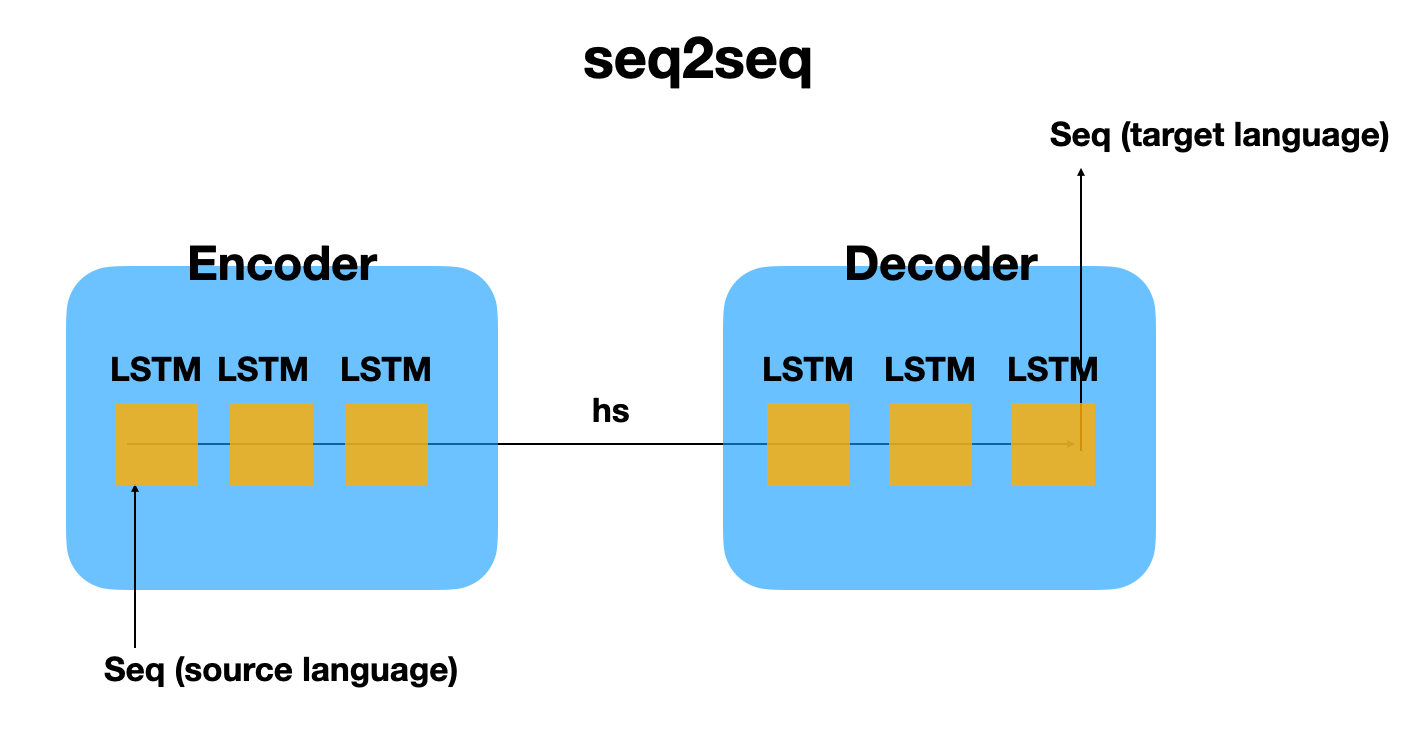

In [38]:
Image('22.png',width=700)

**seq2seq:**
  
-  인코더 + 디코더  
- 교사 강요 teacher forcing 사용 (모델 학습을 돕는다)  
  
**절차:**  
  
- (1) 예측을 저장하는 텐서 생성  
- (2) (1)을 전부 0으로 채워진 텐서로 초기화
- (3) 예측을 통해 (2)에서 초기화된 텐서를 업데이트  
  
**크기:**  
  
위에서 초기화된 예측-텐서의 크기: (타겟 문장의 length, 배치 사이즈의 width, 타겟 단어 집합 크기의 depth)

In [51]:
out = np.array([[1,2,3,4],[2,3,4,5]])
print(out)
print(out.argmax(1))

[[1 2 3 4]
 [2 3 4 5]]
[3 3]


In [16]:
class Seq2Seq(nn.Module):

    def __init__(self, encoder, decoder, device):

        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_rate=0.5):

        target_length = trg.shape[0]
        batch_size = trg.shape[1]
        target_vocab_size = self.decoder.output_dims

        outputs = torch.zeros(target_length, batch_size, target_vocab_size).to(self.device) # 예측을 저장할 텐서를 0으로 초기화

        # input sentence --> Encoder --> h, cell
        h, cell = self.encoder(src)

        # output 시퀀스에서 각 step에 대한 예측을 하기 위해 decoder를 loop해보자.
        # 첫 시작은 <sos>. 이미 이것이 TARGET에 포함되어 있다. 섹션 1.1 참고하라.
        input=trg[0,:]

        for t in range(1, target_length): # trg[0]은 <sos>이고, 우리가 관심이 있는 것은 예측되는 단어인 trg[1]부터다.

            output, h, cell = self.decoder(input, h, cell)
            outputs[t] = output

            top = output.argmax(1) # 각 t에, Decoder에서 출력된 2차원 형태의 output에서 가장 큰 수의 index 반환

            input = trg[t] if (random.random() < teacher_forcing_rate) else top

        return outputs

In [17]:
input_dimensions = len(SOURCE.vocab)
output_dimensions = len(TARGET.vocab)
print(input_dimensions, output_dimensions)
encoder_embedding_dimensions = 256
decoder_embedding_dimensions = 256
hidden_layer_dimensions = 512
number_of_layers = 2
encoder_dropout = 0.5
decoder_dropout = 0.5

5893 7855


In [18]:
encod = Encoder(input_dimensions,
                encoder_embedding_dimensions,
                hidden_layer_dimensions,
                number_of_layers,
                encoder_dropout)

decod = Decoder(output_dimensions,
                decoder_embedding_dimensions,
                hidden_layer_dimensions,
                number_of_layers,
                decoder_dropout)

model = Seq2Seq(encod, decod, device).to(device)
model.type

<bound method Module.type of Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(5893, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(7855, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=7855, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)>

# 5. 모델 훈련시키기

## 5.1 초기화  
  
현재 우리 모델은 모든 부분에 0의 가중치로 초기화했다. random으로 초기화 하는 것은 학습에 도움을 줄 수 있다. 여기서 우리는 우리의 모델을 random 가중치를 부여하여 학습시킬 것이다.

In [19]:
def initialize_weights(m):

    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.1, 0.1)# -0.1 에서 0.1로 초기화

model.apply(initialize_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(5893, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(7855, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=7855, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

## 5.2 Optimizer, Loss functions  
  
- multi-class 분류를 수행하는 cross-entropy loss 사용  
- cs231n에서 좋은 성능을 제공한다고 알려진 Adam 을 optimizer로 사용

In [20]:
optimizer = optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss(ignore_index=TARGET.vocab.stoi[TARGET.pad_token]) 

## 5.3 Train

In [21]:
def train(model, iterator, optimizer, criterion, clip):

    model.train()
    epoch_loss = 0 # init

    for i, batch in enumerate(iterator):

        src = batch.src # loop 내에서 번역된 src를 추출하고, 이 문장의 정답 번역인 trc도 추출한다.
        trg = batch.trg
        optimizer.zero_grad()
        output=model(src,trg) # 모델을 통해 output 계산

        # "예측 문장과 정답 문장을 비교함으로싸" 모델의 예측에 대한 loss를 계산
        ## loss를 비교하게 해주는 2 개의 텐서를 만들기 위해 크기 재조정
        output_dims = output.shape[-1]
        output = output[1:].view(-1,output_dims)
        trg = trg[1:].view(-1)

        loss = criterion(output,trg)
        loss.backward()

        # grad exploding을 막기 위해 clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(),clip)

        #grad descent를 통해 params 업데이트를 수행하기 위해 step 마다 최적화 실행
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)


# 6. 평가  
  
얼마나 모델이 이전에 본 적 없는 data를 번역할 때 잘 수행하는지 평가하기 위해 network에서 검증 데이터의 손실을 계산해보자. 이것은 위의 `def train()`과 거의 비슷하다.



In [22]:
def evaluate(model, iterator, criterion):

    model.eval()
    epoch_loss = 0

    with torch.no_grad(): # 우리는 여기서 가중치weight를 업데이트하지 않기 때문에, 이와 같이 기술한다.

        for i,batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src,trg,0) # teacher forcing 을 off. 왜냐하면 우리는 이 검증 작업에서 unseen data에 대한 모델의 수행 능력을 평가하고 싶기 때문.
            output_dim = output.shape[-1]

            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()

        return epoch_loss / len(iterator)

# 7. Loss 계산

In [23]:
epochs = 10
grad_clip = 1
lowest_validation_loss = float('inf') # 가장 낮은 검증 data에 대한 loss를 제한하지 않는다.

Epoch: 01 | Time: 55.0s
	Train Loss: 4.6948
	 Val. Loss: 4.6000
Epoch: 02 | Time: 54.0s
	Train Loss: 3.9916
	 Val. Loss: 4.3425
Epoch: 03 | Time: 55.0s
	Train Loss: 3.6545
	 Val. Loss: 4.0754
Epoch: 04 | Time: 55.0s
	Train Loss: 3.3843
	 Val. Loss: 3.9144
Epoch: 05 | Time: 55.0s
	Train Loss: 3.1837
	 Val. Loss: 3.8081
Epoch: 06 | Time: 54.0s
	Train Loss: 3.0250
	 Val. Loss: 3.7646
Epoch: 07 | Time: 55.0s
	Train Loss: 2.8677
	 Val. Loss: 3.6693
Epoch: 08 | Time: 55.0s
	Train Loss: 2.7280
	 Val. Loss: 3.6242
Epoch: 09 | Time: 54.0s
	Train Loss: 2.5961
	 Val. Loss: 3.6763
Epoch: 10 | Time: 54.0s
	Train Loss: 2.4804
	 Val. Loss: 3.6236


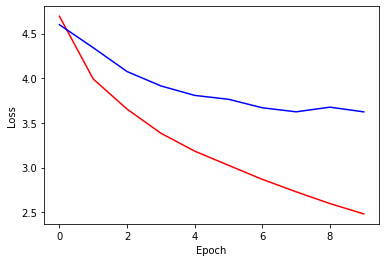

In [24]:

train_losses=[]
valid_losses=[]

for epoch in range(epochs):

    start_time = time.time()

    train_loss = train(model,train_iterator, optimizer, criterion, grad_clip)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time()

    if valid_loss < lowest_validation_loss:
        lowest_validation_loss = valid_loss
        torch.save(model.state_dict(), 'seq2seq.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {np.round(end_time-start_time,0)}s')
    print(f'\tTrain Loss: {train_loss:.4f}')
    print(f'\t Val. Loss: {valid_loss:.4f}')
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

plt.plot(range(10), train_losses,'-r')
plt.plot(range(10),valid_losses,'-b')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

학습을 통해 우리는 모델의 train loss 와 eval loss 모두 떨어지는 것을 볼 수 있다.

# 7. 모델 평가하기

모델을 평가하기 위해, 우리는 데이터의 test set을 가지고 우리 모델을 통해 영어 문장이 독어 문장으로 잘 번역하는지 평가해볼 것이다. 우리는 여기서 모델이 정확히 예측하는지 평가하기 위해, 정답과 우리의 예측값을 비교해볼 것이다.

- 번역을 확인하는 함수는 evaluate 와 거의 비슷하다. 하지만 우리는 여기서 loss에 대해 관심을 갖지 않고, 오직 예측된 출력값에 대해서만 관심을 갖는다. 대신에, 우리는 여기서 모델이 출력되는 예측 문장(German)의 각 단어의 index를 알기 위해 argmax를 사용한다.  
  
- 그러면, 우리는 독어 단어 집합에서 실제 예측된 단어를 얻기 위해 이 인덱스를 사용할 수 있다.  
  
- 아래 코드에서 [1:-1]의 사용은 시작과 끝에 있는 sos, eos를 제외시키기 위해서이다.

In [25]:
def translate(model, iterator, limit = 4):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):
            if i < limit :
                
                src = batch.src
                trg = batch.trg

                output = model(src, trg, 0)
                preds = torch.tensor([[torch.argmax(x).item()] for x in output])
                
                print('English Input: ' + str([SOURCE.vocab.itos[x] for x in src][1:-1][::-1]))
                print('Correct German Output: ' + str([TARGET.vocab.itos[x] for x in trg][1:-1]))
                print('Predicted German Output: ' + str([TARGET.vocab.itos[x] for x in preds][1:-1]))
                print('\n')

In [26]:
_, _, eval_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = 1, 
    device = device)

In [27]:
output = translate(model, eval_iterator)

English Input: ['two', 'men', 'wearing', 'hats', '.']
Correct German Output: ['zwei', 'männer', 'mit', 'mützen', '.']
Predicted German Output: ['zwei', 'männer', 'mit', 'hüten', '.']


English Input: ['young', 'woman', 'climbing', 'rock', 'face']
Correct German Output: ['junge', 'frau', 'klettert', 'auf', 'felswand']
Predicted German Output: ['eine', 'frau', 'frau', ',', 'die']


English Input: ['a', 'woman', 'is', 'playing', 'volleyball', '.']
Correct German Output: ['eine', 'frau', 'spielt', 'volleyball', '.']
Predicted German Output: ['eine', 'frau', 'spielt', 'tennis', '.']


English Input: ['three', 'men', 'are', 'walking', 'up', 'hill', '.']
Correct German Output: ['drei', 'männer', 'gehen', 'bergauf', '.']
Predicted German Output: ['drei', 'männer', 'laufen', 'durch', 'den']




# References  
  
[1] Thomas Dop,'Hands-On Natural Language Processing with PyTorch 1.x: Build Smart, AI-driven Linguistic Applications Using Deep Learning and NLP Techniques' (PACKT, July 9, 2020)  
[2] cs224n lecture 8